In [2]:
import pandas as pd
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
import numpy as np
from transformers import BertModel, BertTokenizer
import torch
from tqdm import tqdm

#clustering
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score
from functools import reduce

#ext
import math
import yake
from nltk.corpus import stopwords
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import itertools
nltk.download('stopwords')
from numpy import exp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator
from collections import defaultdict
import rouge

#combine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import operator
from bert_score import score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data Testing TripAdvisor

Data TripAdvisor yang di-*import* merupakan hasil dari pembagian data, dimana untuk proses penggabungan abstraktif dan ekstraktif menggunakan data *testing*

In [5]:
ext = pd.read_json('./test.json').reset_index()
ext = ext.drop('Unnamed: 0', axis=1)

In [6]:
ext.head()

,index,review,abstractive,kategori,review_cln,ext_review
0,203,Salah satu kawasan wisata di Jawa Timur yang ...,Tempat wisata Bromo dapat dinikmati dengan mel...,labeled-attraction,salah satu kawasan wisata di jawa timur yang s...,biaya sewa jeep mulai berangkat sampai selesai...
1,226,Tempat ini berlokasi di Ubud. Sekitar satu s...,Tegalalang ubud Bali cocok untuk menghilangkan...,labeled-attraction,tempat ini berlokasi di ubud [SEP] sekitar sat...,hanya 10ribu rupiah untuk biaya masuknya. [SEP...
2,7,Dari awal pertama kali baru buka ( saat itu h...,Novotel berlokasi di pinggiran kota Surabaya. ...,labeled-hotel,dari awal pertama kali baru buka saat itu hany...,terima kasih untuk bu sherly dan jajaran semua...
3,63,"Lokasi hotel sangat strategis dekat kemana, m...",Grand Kangen memiliki kamar yang luas dan fasi...,labeled-hotel,lokasi hotel sangat strategis dekat kemana mal...,untuk fasilitas kamar sangat oke. [SEP] ketika...
4,45,Citycation kali ini cobain daerah Casablanca ...,Wyndham Casablanca Jakarta Hotel adalah hotel ...,labeled-hotel,citycation kali ini coba daerah casablanca jak...,kamarnya kamar mandinya lobbynya kolam renangn...


Selanjutnya data disimpan dalam bentuk *dictionary* untuk memudahkan proses selanjutnya.

In [7]:
doc = []
for i in range(len(ext)):
  doc.append({
      'sentence' : ext['review_cln'][i].split('[SEP]')
  })

### Embedding Kalimat Menggunakan Model BERT

Tahapan pertama melakukan inisialisasi tokenisasi dan model yang digunakan untuk BERT. Panjang token sejumlah 512 sesuai dengan panjang maksimal model BERT

In [178]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1', padding="max_length", truncation=True, max_length=512)
model = BertModel.from_pretrained('indobenchmark/indobert-base-p1', output_hidden_states = True)

Pembuatan fungsi untuk menyimpan *hidden layer* sebagai embedding kalimat dari model BERT

In [9]:
# Inisialisasi awal untuk gpu, jumlah hidden layer terakhir untuk digabung menjadi satu vektor, dan pooling strategy
use_gpu = False 
n_combined_hidden_states = 2
pooling_mode = 1 
if use_gpu:
    model.to('cuda')

# Mengambil hidden layer model BERT
def sentence2bert_hidden_states(sentence, tokenizer, model, use_gpu = True):
    indexed_tokens = tokenizer.encode(sentence)
    tokens_tensor = torch.tensor([indexed_tokens])
    if use_gpu:
        tokens_tensor = tokens_tensor.to('cuda')
    with torch.no_grad():
        outputs = model(tokens_tensor)        
    hidden_states = outputs[2]
    hidden_states = torch.stack(hidden_states, dim=0)
    hidden_states = torch.squeeze(hidden_states, dim=1)
    hidden_states = hidden_states.permute(1,0,2)    
    return hidden_states, indexed_tokens

# Menggabungkan hidden layer 
def combine_hidden_states(hidden_states, n_summands):
    n = hidden_states.shape[0]    
    assert n_summands <= hidden_states.shape[1]    
    combined = np.empty((hidden_states.shape[0],hidden_states.shape[2]))
    for i in range(n):
        combined[i,:] = torch.sum(hidden_states[i][-n_summands:], dim=0).cpu()[:]
    return combined

# Melakukan proses embedding token
def sentence2token_embeddings(sentence, tokenizer, model, use_gpu = True, n_combined_hidden_states = 4):
    hidden_states, indexed_tokens = sentence2bert_hidden_states(sentence, tokenizer, model, use_gpu)
    token_embeddings = combine_hidden_states(hidden_states, n_combined_hidden_states)
    return token_embeddings, indexed_tokens

# Melakukan proses embedding kalimat menggunakan mean
def sentence2embedding(sentence, tokenizer, model, use_gpu = True, n_combined_hidden_states = 4, pooling_mode = 0):
    token_embeddings, indexed_tokens = sentence2token_embeddings(sentence, tokenizer, model, use_gpu, n_combined_hidden_states)
    if pooling_mode == 0:
        return token_embeddings[0]
    else:
        return np.mean(token_embeddings, axis = 0)

# Menyimpan kalimat dan hasil embedding kalimatnya
def text2sentence_embeddings(text_sentences, tokenizer, model, use_gpu = True, n_combined_hidden_states = 2, pooling_mode = 0):
    n_text_sentences = len(text_sentences)
    text_embeddings = np.empty((n_text_sentences, model.config.hidden_size))
    for i in range(n_text_sentences):
        text_embeddings[i,:] = sentence2embedding(text_sentences[i], tokenizer, model, use_gpu, n_combined_hidden_states, pooling_mode)[:]
    return text_embeddings

def sentence_embeddings(data):
  text_embeddings = text2sentence_embeddings(data, 
                                                tokenizer, 
                                                model, 
                                                use_gpu, 
                                                n_combined_hidden_states, 
                                                pooling_mode)
  return text_embeddings

### Metode Clustering untuk Penghapusan Topik yang Tidak Penting

Pemilihan metode clustering berdasarkan nilai Silhouette Coefficient (SC), Davies Bouldin Index (DBI), dan Halinksi Harabaz (HB). Berikut fungsi untuk ketiga metode evaluasi unsupervised

In [10]:
def dbi (model_c, embedding, k_max):
  if model_c == 'Agglomerative':
    model = AgglomerativeClustering(k_max).fit(embedding)
  elif model_c =='KMeans':
    model = KMeans(k_max).fit(embedding)
  else:
    model = KMedoids(k_max, init='k-medoids++').fit(embedding)

  dbi = davies_bouldin_score(embedding, model.labels_)

  return dbi

In [11]:
def chi(model, embedding, k_max):
  if model=='Agglomerative':
    model = AgglomerativeClustering(k_max).fit(embedding)
  elif model=='KMeans':
    model = KMeans(n_clusters=k_max).fit(embedding)
  else:
    model = KMedoids(k_max, init='k-medoids++').fit(embedding)

  chi = calinski_harabasz_score(embedding, model.labels_)
  
  return chi

Metode Silhouette juga digunakan untuk menghitung jumlah klaster optimal

In [12]:
def get_silhouette (model_c, embedding, k_max):
  silhouette = {}

  for k in range(2, k_max):
    if model_c =='Agglomerative':
      model = AgglomerativeClustering(n_clusters=k).fit(embedding)
    elif model_c =='KMeans':
      model = KMeans(n_clusters=k).fit(embedding)
    else:
      model = KMedoids(n_clusters=k, init='k-medoids++').fit(embedding)
    silhouette[k] = silhouette_score(embedding, model.labels_)

  max_value = max(silhouette.values())
  max_index = max(silhouette, key=silhouette.get)

  return max_index, max_value

Metode Elbow digunakan untuk menghitung jumlah klaster optimal. Dari metode Silhouette dan Elbow akan digunakan jumlah klaster tertinggi

In [13]:
def elbow(model_c, embedding, k_max):
  if model_c=='Agglomerative':
    elb_visualizer = KElbowVisualizer(AgglomerativeClustering(), k=(2,k_max), timings=False).fit(embedding)
  elif model_c=='KMeans':
    elb_visualizer = KElbowVisualizer(KMeans(), k=(2,k_max), timings=False).fit(embedding)
  else:
    elb_visualizer = KElbowVisualizer(KMedoids(init='k-medoids++'), k=(2,k_max), timings=False).fit(embedding)

  max_index = elb_visualizer.elbow_value_
  max_value = elb_visualizer.elbow_score_
  
  return max_index, max_value

Tahapan awal dilakukan pengurangan dimensi menggunakan PCA karena pada saat menggunakan dimensi asli dari model BERT yaitu 729 menghasilkan jumlah klaster yang lebih banyak. Hal ini akan menyebabkan metode clustering lebih sensitif terhadap pengelompokkan kalimatnya.

Tahapan berikutnya mencari jumlah klaster optimal menggunakan silhouette dan elbow, dimana jumlah klaster tertinggi akan digunakan sebagai inisialisasi jumlah klaster untuk metode clustering.

In [14]:
def n_clustering(model_c, embeddingr, k_max):
    pca = PCA(n_components=2)
    embedding = pca.fit_transform(embeddingr)
    clus = []

    ss, score_s = get_silhouette(model_c, embedding, k_max)
    el, score_e = elbow(model_c, embedding, k_max)

    clus = [ss, el]
            
    print(clus)
    clus.sort(reverse=True)
    clus_opt = {x:clus.count(x) for x in clus}
    index_max = max(clus_opt, key=clus_opt.get)
    print(index_max)
    
    score_chi = chi(model_c, embedding, index_max)
    score_dbi = dbi(model_c, embedding, index_max)
    alscore = [score_s, score_chi, score_dbi]
    
    return index_max, alscore

def clustering(model_c, embedding,n_cluster):
    if model_c =='Agglomerative':
      clus = AgglomerativeClustering(n_clusters=n_cluster).fit_predict(embedding)
    elif model_c =='KMeans':
      clus = KMeans(n_clusters=n_cluster).fit_predict(embedding)
    else:
      clus = KMedoids(n_clusters=n_cluster, init='k-medoids++').fit_predict(embedding)

    return clus

Pencarian jumlah klaster optimal dilakukan dari rentang 2 sampai 10. Penentuan jumlah maksimal berdasarkan penelitian sebelumnya [Cahyaningtyas dkk., 2021](https://doi.org/10.22219/kinetik.v6i3.1300) dimana topik yang muncul dalam ulasan tidak lebih dari 10.

Pada file perbandingan_clustering.ipynb telah dilakukan proses pencarian metode clustering maksimal untuk Data TripAdvisor sehingga pada fungsi di bawah hanya melakukan eksekusi program untuk metode terbaik yaitu K-Means 

In [15]:
def clustering_sent(model_c, data, cls_max=False):
    data_ext = {}

    for d in range(len(data)):
        y = data[d]['sentence']
        embedding = sentence_embeddings(y)
        tmp_txt = []
        tmp_clus = []

        k_max = 10
        
        print('data '+str(d))
        cls, score = n_clustering(model_c, embedding, k_max)
        agg = clustering(model_c, embedding,cls)

        for i in range(len(y)):
            tmp_txt.append(y[i])
            tmp_clus.append(agg[i])
        
        data_ext[d] = {}
        data_ext[d]['text'] = tmp_txt
        data_ext[d]['cluster'] = tmp_clus
        data_ext[d]['score_clus'] = score

    return data_ext

data 0
[8, 4]
8
data 1
[3, 3]
3
data 2
[2, 4]
4
data 3
[3, 3]
3
data 4
[3, 3]
3
data 5
[3, 4]
4
data 6
[3, 4]
4
data 7
[9, 4]
9
data 8
[6, 4]
6
data 9
[3, 4]
4
data 10
[3, 3]
3
data 11
[8, 4]
8
data 12
[9, 4]
9
data 13
[9, 3]
9
data 14
[5, 4]
5
data 15
[2, 4]
4
data 16
[3, 3]
3
data 17
[2, 4]
4
data 18
[3, 4]
4
data 19
[3, 4]
4
data 20
[3, 3]
3
data 21
[3, 4]
4
data 22
[4, 4]
4
data 23
[3, 3]
3
data 24
[6, 5]
6
data 25
[3, 4]
4
data 26
[8, 5]
8
data 27
[6, 4]
6
data 28
[8, 5]
8
data 29
[4, 4]
4


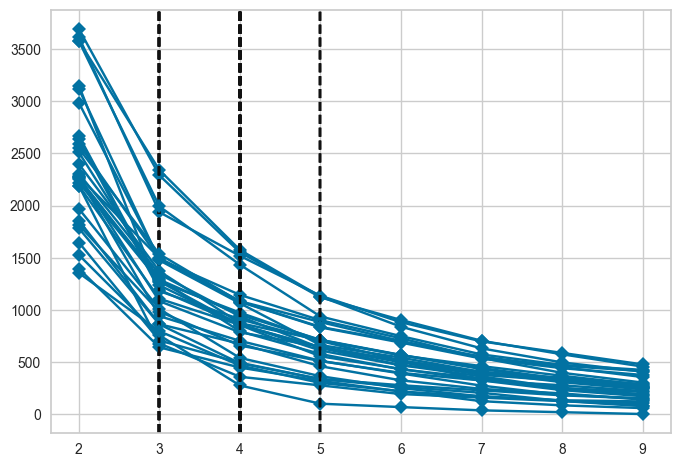

In [16]:
model_c = 'KMeans'
data_ext = clustering_sent(model_c, doc)

### Tahapan Ekstraktif Menggunakan Kombinasi Fitur: Relevansi, Keterbaruan Informasi/*Novelty*, Posisi, dan *Sentiment-keyword* (RKiPS) 

**Fitur Relevansi** didapatkan dari kedekatan kalimat dengan centroid. Fitur ini menunjukkan bahwa nilai yang tinggi memiliki kedekatan informasi dengan topik utama. Kedekatan antara kalimat dengan centroid dilakukan berdasarkan perhitungan cosine similarity.

In [17]:
# Fungsi untuk menghitung cosine similarity
def cosine(u, v):
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [18]:
# Fungsi untuk menghitung relevansi dengan menggunakan parameter centroid dan embedding kalimat
def content_relevance(centroid,hypothesis_embeddings):
  d = {}
  for sentence,embed in hypothesis_embeddings.items():
    d[sentence] = cosine(centroid,embed)
    
  return d

**Fitur keterbaruan informasi/*Novelty*** digunakan mendapatkan informasi baru dan mengurangi redundansi dari ringkasan. Fitur ini berdasarkan nilai *threshold* untuk menghitung suatu kalimat apakah memiliki informasi baru atau tidak. Suatu kalimat akan dibandingkan dengan kalimat lain pada dokumen yang sama untuk melihat kedekatan antar kalimatnya. Terdapat 3 kondisi untuk fitur keterbaruan informasi/*novelty* antara lain:
1. Apabila suatu kalimat memiliki kedekatan antar kalimat lainnya yang rendah dibandingkan nilai *threshold* maka kalimat tersebut memiliki nilai *novelty* yang tinggi yaitu 1.
2. Apabila suatu kalimat memiliki kedekatan antar kalimat lainnya yang lebih tinggi dibandingkan nilai *treshold* maka terdapat kondisi berikutnya yang perlu dicek yaitu apabila kalimat memiliki nilai relevansi yang tinggi dibandingkan dengan kalimat lainnya yang ada di dokumen tersebut maka memiliki nilai *novelty* yang tinggi yaitu 1.
3. Apabila tidak memenuhi kondisi diatas maka memiliki nilai -> 1-max_similarity.

In [81]:
# Fungsi untuk menghitung keterbaruan informasi/novelty dengan menggunakan parameter nilai relevansi dan embedding kalimat
def sentence_novelty(content_relevance_score,hypothesis_embeddings):
  novel_sentences = {}
  TAU = 0.95
  for sent1,embed1 in hypothesis_embeddings.items():
    max_similarity = 0
    for sent2,embed2 in hypothesis_embeddings.items():
      if sent1!=sent2 and cosine(embed1,embed2)>max_similarity:
          max_similarity = cosine(embed1,embed2)
          tmp_sent2 = sent2

    # Kondisi 1
    if max_similarity<TAU:
      novel_sentences[sent1] = 1

    # Kondisi 2
    elif max_similarity>TAU:
      if content_relevance_score[sent1]>content_relevance_score[tmp_sent2]:
        novel_sentences[sent1] = 1
      else:
        novel_sentences[sent1] = 1-max_similarity

    # Kondisi 3
    else:
      novel_sentences[sent1] = 1-max_similarity

  return novel_sentences

**Fitur posisi** menerapkan konsep bahwa kalimat pada posisi pertama memiliki nilai yang lebih tinggi dibandingkan kalimat yang jauh dari posisi pertama.

In [20]:
def sentence_position(hypothesis):
  score_sent = {}
  for i,sent in enumerate(hypothesis):
      score_sent[sent] = max(0.5,math.exp(-(i+1)/(len(hypothesis)**(1/3))))
  
  return score_sent

**Fitur *sentiment-keyword*** terdiri dari *sentiment* yang digunakan untuk mendapatkan nilai opini dari sebuah kalimat yang berfungsi untuk menilai sebuah topik bahasan, sedangkan *keyword* untuk mendapatkan nilai penting berupa *n-gram* pada sebuah dokumen.

In [21]:
# Fungsi untuk mengekstraksi keyword menggunakan model YAKE
def keyword_extractor(text):
    kword = []
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(text)
    
    for kw in range(len(keywords)):
        kword.append(keywords[kw])
    
    keywords = sorted(kword,key=lambda x:(-x[1],x[0]))

    return keywords

Pada bagian *keyword* diawali dengan penghapusan *stopwords* agar mengurangi *keyword* yang memiliki kata-kata yang tidak penting seperti kata hubung. Kemudian model Yake akan mengekstraksi keyword berdasarkan dokumen. Kalimat-kalimat yang memiliki atau terdiri dari kata *keyword* maka akan dihitung sebagai fitur *keyword*, dimana nilai setiap *keyword* dihasilkan dari model Yake. Nilai-nilai *keyword* yang telah terkumpul akan dijumlahkan sehingga suatu kalimat akan memiliki nilai akhir untuk *keyword*.

In [22]:
# Fungsi untuk menghapus stopwords untuk proses ekstraksi keyword
def remove_stop_words(text):
    stop_factory = stopwords.words('indonesian')
    clean_words = []
    text = word_tokenize(text)
    for word in text:
        if word not in stop_factory:
            clean_words.append(word)
    return " ".join(clean_words)

def stem_process(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return stemmer.stem(text)

def key_clean_process(text, stem=False):
    text = remove_stop_words(text)
    if stem==True:
      text = stem_process(text)
    return text

In [23]:
# Proses ekstraksi keyword dengan fungsi yang telah dibuat sebelumnya
data_k = []
for d in range(len(doc)):
  clean_ = ' '.join(doc[d]['sentence'])
  clean_ = key_clean_process(clean_)
  data_k.append(clean_)

data_key = {}
for i in range(len(data_k)):
  data_key[i] = (keyword_extractor(data_k[i]))

In [24]:
# Contoh hasil keyword dari dokumen dengan indeks i=0
data_key[0]

[('mencapai puncak gunung', 0.00038882991556179694),
 ('puluh ribu seratus', 0.0003859814747092455),
 ('puncak gunung bromo', 0.00038211364615548925),
 ('ribu jalan gelap', 0.0003797685574313523),
 ('padang savana savana', 0.0003725015693419516),
 ('menyaksikan matahari terbit', 0.0003680906770200601),
 ('fotogradi pasir berbisik', 0.00036615226044093045),
 ('pasir berbisik dimana', 0.00036615226044093045),
 ('kawasan pasir berbisik', 0.0003655226117298274),
 ('padang savana pasir', 0.00036027213148515525),
 ('bromo pasir berbisik', 0.00035982957433348695),
 ('kawah puluh ribu', 0.0003454549109396373),
 ('ribu seratus ribu', 0.000340030804224589),
 ('berbisik kawah bromo', 0.0003342738678748449),
 ('savana pasir berbisik', 0.00032995505939695187),
 ('berbisik padang savana', 0.0003028827288016419),
 ('pasir berbisik kawah', 0.0002964753028106403),
 ('matahari terbit sunrise', 0.00019027513855199104),
 ('ratus ribu jalan', 0.00018995895913567393),
 ('pasir berbisik padang', 0.0001464738

Pada bagian *sentiment* didapatkan nilai dari model VADER yang memiliki leksikon Bahasa Inggris. Oleh karena itu, penerapan VADER pada Bahasa Indonesia diawali dengan menerjemahkan dokumen Bahasa Indonesia ke Bahasa Inggris dengan menggunakan *library* "deep_translator"

In [26]:
# Fungsi untuk mendapatkan nilai sentiment menggunakan model VADER
vader_sentiment = SentimentIntensityAnalyzer()
def vader_sentiment_scores(text):
  score = vader_sentiment.polarity_scores(text)
  return score['compound']

def prediksiSentiment(kalimat):
    # Penerjemah Bahasa Indonesia ke Bahasa Inggris
    translated = GoogleTranslator(source='auto', target='en').translate(kalimat)
    wordlist = len(word_tokenize(kalimat))
    val = abs(vader_sentiment_scores(translated)/wordlist)
    return val

In [27]:
def normalization_sen(text, keyword):
  lprob = []
  for i,sent in enumerate(text):
    val = prediksiSentiment(sent)
    
    nk = []
    for k in range(len(keyword)):
      split_keyword = keyword[k][0].split()
      for sk in split_keyword:
        if sk in sent:
          nk.append(keyword[k][1]) 
    key = np.sum(nk)
        
    prob = key + val
    lprob.append(prob)

  score_sent = {}
  for i,sent in enumerate(text):
    score_sent[sent] = lprob[i]
  
  return score_sent

Penggabungan kombinasi fitur yang telah dijelaskan di atas serta perhitungan nilai akhir dengan perkalian bobot untuk setiap fitur, dimana bobot *alpha* dikalikan dengan fitur relevansi, bobot *beta* dikalikan dengan fitur keterbaruan informasi/*novelty*, bobot *gamma* dikalikan dengan fitur posisi, dan bobot *teta* dikalikan dengan fitur *sentiment-keyword*.

Bagian ini juga merupakan proses lanjutan untuk penhapusan topik yang tidak penting dari hasil *clustering*. Pada variabel after_clus adalah dokumen baru setelah penghapusan topik tidak penting dengan ketentuan jumlah anggota klaster lebih dari 2.

In [82]:
def total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, sentiment, sentence_pos):
  final_score = {}
  for sent in content_relevance_score:
    final_score[sent] = (alpha*content_relevance_score[sent])+(beta*sentence_novelty_score[sent])+(gamma*sentence_pos[sent])+(teta*sentiment[sent])
  final_score = {k: v for k, v in sorted(final_score.items(), key=lambda item: item[1],reverse=True)}
      
  return final_score

def convert_to_embeddings(alpha, beta, gamma, teta, text_sentences, text_embeddings, keyword, sentence_pos):
  hypothesis_embeddings = {}
  sum = 0
  index = 0

  for sent in text_sentences:
    var = text_embeddings[index]
    sum += var
    hypothesis_embeddings[sent] = var
    index += 1

  centroid = sum/len(text_sentences)
  
  content_relevance_score = content_relevance(centroid,hypothesis_embeddings)
  sentence_novelty_score = sentence_novelty(content_relevance_score,hypothesis_embeddings)
  phrasa_score = normalization_sen(text_sentences, keyword)
  return total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, phrasa_score, sentence_pos)

def iter_ext(data, data_pos, alpha, beta, gamma, teta):
    result_dict = defaultdict(list)

    for index,v in tqdm(data.items()):

        datapoint_length = {x:data[index]['cluster'].count(x) for x in data[index]['cluster']}
        sentence_pos = sentence_position(data_pos[int(index)]['sentence'])
        after_clus = []
        for c in range(len(datapoint_length)):
            txt = []

            for t in range (len(data[index]['text'])):
                if data[index]['cluster'][t] == c:
                    txt.append(data[index]['text'][t])

            if len(txt) > 2:
               after_clus.extend(txt)
               
        text_embeddings = sentence_embeddings(after_clus)
        predicted_summary = convert_to_embeddings(alpha, beta, gamma, teta, after_clus, text_embeddings, data_key[int(index)], sentence_pos) 
        result_dict[index].append(predicted_summary)

    return result_dict

extract_skp = iter_ext(data_ext, doc, 0.5, 0.2, 0.2, 0.1)

100%|██████████| 30/30 [05:31<00:00, 11.04s/it]


In [133]:
def summary2(text):
    extractive = []
    for dc,v in text.items():
        tmp_ext = []
        val_cls = [v for v in text[dc][0].values()]
        key_cls = [k for k in text[dc][0].keys()]
        for vc in range(len(val_cls)):
          if len(tmp_ext) <= 10:
            tmp_ext.append(key_cls[vc])
            
        extractive.append('\n'.join(tmp_ext))
    return extractive

In [134]:
acsum = []
for smm in range(len(ext['abstractive'])):
  acsum.append(ext['abstractive'][smm].replace('.','.\n'))

In [237]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'],
                           max_n=2,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=True,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=False)
raw_ext1 = summary2(extract_skp)
scores_ext = evaluator.get_scores(raw_ext1, acsum)
_, _, bertscores_ext = score(raw_ext1, acsum, model_type="indobert-base-p1", num_layers=12)

### Tahapan Abstraktif Menggunakan Model *Pre-trained* BERT dan GPT2 

Pada tahapan ini diawali dengan proses *fine-tuning* untuk model BERT dan GPT2. Kode untuk *fine-tuning* berada di file ... . Setelah mendapatkan model yang telah dilatih dengan Data TripAdvisor, maka untuk uji coba pembangunan kalimat ringkasan abstraktif menggunakan data *testing*.

Persiapan tokenisasi dilakukan untuk kedua model dimana pada model BERT digunakan sebagai *encoder* maupun *decoder* sehingga proses tokenisasi dilakukan untuk model BERT saja. Sedangkan pada model GPT2 memerlukan *encoder* yaitu menggunakan BERT sehingga pembangunan *encoder-decoder* berbasis BERT sebagai *encoder* dan GPT2 sebagai *decoder*.

In [ ]:
from transformers import EncoderDecoderModel
from transformers import GPT2Tokenizer, BertTokenizer

In [ ]:
from datasets import Dataset

# Menggunakan library dataset untuk melakukan batch data
test_data = Dataset.from_pandas(ext)

**BERT**

Tokenisasi berdasarkan model BERT dan terdapat penambahan token spesial yaitu BOS = CLS dan EOS = SEP. Setelah itu, pemanggilan model yang telah di-*fine-tuning* untuk proses pembangunan peringkasan.

In [160]:
# Persiapan model tokenisasi dan penambahan token spesial
bert_tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
bert_tokenizer.bos_token = bert_tokenizer.cls_token
bert_tokenizer.eos_token = bert_tokenizer.sep_token

In [139]:
# Menggunakan model BERT yang telah di-fine-tuning
model_bert = EncoderDecoderModel.from_pretrained("ranggics/bert2bert")

In [165]:
batch_size = 16 

# Mapping data untuk peringkasan abstraktif model BERT
def generate_summary_bert(batch):
    # Melakukan tokenisasi dan menentukan jumlah token maksimal
    inputs = bert_tokenizer(batch["review_cln"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    # Proses pembangunan ringkasan dengan beam search
    outputs = model_bert.generate(input_ids, max_length=90, attention_mask=attention_mask, num_beams=10,
                                repetition_penalty=5.0, num_return_sequences=1)

    # Decoding dan penghapusan token spesial
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [166]:
# Proses peringkasan abstraktif menggunakan BERT untuk seluruh data testing
result_bert = test_data.map(generate_summary_bert, batched=True, batch_size=batch_size)
abs_pred_bert = result_bert["pred"]

100%|██████████| 2/2 [05:16<00:00, 158.49s/ba]


In [236]:
# Evaluasi hasil model BERT
abs_pred_bert = [x.replace('. ','\n') for x in abs_pred_bert]
scores_bert = evaluator.get_scores(abs_pred_bert, acsum)
_, _, bertscores_bert = score(abs_pred_bert, acsum, model_type="indobert-base-p1", num_layers=12)

**GPT2**

Tokenisasi berdasarkan model GPT2 dan terdapat penambahan token spesial yaitu BOS = CLS dan EOS = SEP untuk diterapkan pada BERT sebagai *encoder* dan GPT2 sebagai *decoder*. Sedangkan pada model GPT2 terdapat penambahan PAD secara manual. Setelah itu, pemanggilan model yang telah di-*fine-tuning* untuk proses pembangunan peringkasan.

In [147]:
# Menggunakan model GPT2 yang telah di-fine-tuning
model_gpt2 = EncoderDecoderModel.from_pretrained("./bert2gpt/checkpoint-3800")

Some weights of the model checkpoint at ./bert2gpt/checkpoint-3800 were not used when initializing EncoderDecoderModel: ['decoder.transformer.h.2.crossattention.bias', 'decoder.transformer.h.9.crossattention.masked_bias', 'decoder.transformer.h.10.crossattention.masked_bias', 'decoder.transformer.h.1.crossattention.masked_bias', 'decoder.transformer.h.6.attn.masked_bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.11.attn.masked_bias', 'decoder.transformer.h.7.attn.bias', 'decoder.transformer.h.11.crossattention.bias', 'decoder.transformer.h.0.attn.bias', 'decoder.transformer.h.9.attn.masked_bias', 'decoder.transformer.h.8.attn.bias', 'decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transformer.h.4.attn.bias', 'decoder.transformer.h.1.attn.masked_bias', 'decoder.transformer.h.10.attn.bias', 'decoder.transformer.h.10.attn.masked_bias', 'decoder.trans

In [161]:
# Persiapan tokenisasi untuk encoder BERT dan decoder GPT2
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [bert_tokenizer.bos_token] + token_ids_0 + [bert_tokenizer.eos_token]
    return outputs

GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("cahya/gpt2-small-indonesian-522M")
gpt2_tokenizer.pad_token = gpt2_tokenizer.unk_token

In [162]:
# Mapping data untuk peringkasan abstraktif model GPT2
def generate_summary_gpt(batch):
    # Melakukan tokenisasi dan menentukan jumlah token maksimal
    inputs = bert_tokenizer(batch["review_cln"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    # Proses pembangunan ringkasan dengan beam search
    outputs = model_gpt2.generate(input_ids, max_length=90, attention_mask=attention_mask, num_beams=10,
                                repetition_penalty=5.0, num_return_sequences=1)

    # Decoding dan penghapusan token spesial
    output_str = gpt2_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [163]:
# Proses peringkasan abstraktif menggunakan GPT2 untuk seluruh data testing
result_gpt = test_data.map(generate_summary_gpt, batched=True, batch_size=batch_size)
abs_pred_gpt = result_gpt["pred"]

100%|██████████| 2/2 [23:03<00:00, 691.78s/ba]


In [235]:
# Evaluasi hasil model BERT
abs_pred_gpt = [x.replace('. ','\n') for x in abs_pred_gpt]
scores_gpt = evaluator.get_scores(abs_pred_gpt, acsum)
_, _, bertscores_gpt = score(abs_pred_gpt, acsum, model_type="indobert-base-p1", num_layers=12)

### Penggabungan Abstraktif dan Ekstraktif

Penggabungan kalimat abstraktif dan ekstraktif diawali dengan menghapus kalimat dari ekstraktif yang memiliki informasi yang sama dengan kalimat abstraktif. Penghapusan kalimat ekstraktif menggunakan nilai *dissimilarity* yang dibandingkan nilai *treshold*. Apabila nilai *dissmilarity* kurang dari nilai *treshold* maka kalimat ekstraktif akan dihapus.

In [180]:
def selecting_sen(abst, ext, threshold, alpha):
    emb_ext = sentence_embeddings(ext)
    hyb = {}

    tmp_data = abst.copy()
    for n in range(len(ext)):
        h = []
        emb_abst = sentence_embeddings(tmp_data)
        for x in range(len(tmp_data)):
            h.append(1-cosine(emb_abst[x], emb_ext[n]))
        hyb[ext[n]] = np.mean(h)
        tmp_data.append(ext[n])

    sorted_hyb = dict(sorted(hyb.items(), key=operator.itemgetter(1),reverse=True))
    sorted_hyb = list(sorted_hyb)
    
    tmp_cmb = abst.copy()
    for x in range(len(hyb)):
      if hyb[ext[n]] > threshold:
        tmp_cmb.append(sorted_hyb[x])
            

    cln = mmr_sent(tmp_cmb, alpha)
    return cln

MMR (*Maximal Relevance Marginal*) digunakan untuk memilih kalimat sehingga jumlah kalimat yang dihasilkan tidak lebih dari rata-rata jumlah kalimat dokumen. Hal ini akan menjaga nilai evaluasi lebih baik dan menghasilkan dokumen yang ringkas. Proses MMR terdiri dari 3 tahapan yaitu:
1. Menyiapkan kalimat dengan menghapus *stopword* dan *stemming*.
2. Mengubah kalimat menjadi vektor yang berdasarkan Count Vectorizer, dimana vektor dibangun berdasarkan kemunculan-kemunculan kata pada sebuah dokumen.
3. Menghitung MMR berdasarkan kalimat dengan dokumen dan kalimat dengan kalimat yang didapatkan dari hasil MMR dari iterasi sebelumnya.

In [169]:
# Persiapan untuk stemming dan stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def load_stopWords():
	f = open('./stopword.txt', 'r')
	return f.readlines()

filestopwords = load_stopWords()

In [170]:
# Fungsi untuk menghapus stopwords dan vektorisasi
def cleanData(sentence):
	ret = []
	sentence = stemmer.stem(sentence)	
	for word in sentence.split():
		if not word in filestopwords:
			ret.append(word)
	return " ".join(ret)


def getVectorSpace(cleanSet):
	vocab = {}
	for data in cleanSet:
		for word in data.split():
			vocab[data] = 0
	return vocab.keys()
	
def calculateSimilarity(sentence, doc):
	if doc == []:
		return 0
	vocab = {}
	for word in sentence:
		vocab[word] = 0
	
	docInOneSentence = ''
	for t in doc:
		docInOneSentence += (t + ' ')
		for word in t.split():
			vocab[word]=0	
	
	cv = CountVectorizer(vocabulary=vocab.keys())

	docVector = cv.fit_transform([docInOneSentence])
	sentenceVector = cv.fit_transform([sentence])
	return cosine_similarity(docVector, sentenceVector)[0][0]

In [280]:
sentences = []
clean = []
originalSentenceOf = {}
	
import time
start = time.time()

def mmr_sent(text, alpha):
	#Penghapusan stopword dan stemming
	sentences = []
	clean = []
	originalSentenceOf = {}
	parts = text
	for part in parts:
		cl = cleanData(part)
		sentences.append(part)
		clean.append(cl)
		originalSentenceOf[cl] = part		
	setClean = set(clean)
		
	#Menghitung nilai similarity kalimat dengan keseluruhan dokumen		
	scores = {}
	for i in range (len(clean)):
		temp_doc = setClean - set([clean[i]])
		score = calculateSimilarity(clean[i], list(temp_doc))
		scores[sentences[i]] = score
		#print score

	#Menghitung MMR
	n = 10
	tmpalpha = alpha
	summarySet = []
	while n > 0:
		mmr = {}
		for sentence in scores.keys():
			if not sentence in summarySet:
				mmr[sentence] = tmpalpha * scores[sentence] - (1-tmpalpha) * calculateSimilarity(sentence, summarySet)
		try:	
			selected = max(mmr.items(), key=operator.itemgetter(1))[0]	
		except:
			break
		summarySet.append(selected)
		n -= 1
		tmpalpha -= 0.1
	
	return '\n'.join(summarySet)

In [271]:
com_ext = [x.split('\n') for x in raw_ext1]
tmp_ext_con = []
for i in com_ext:
    tmp_ext_con.append([x.strip() for x in i])

In [272]:
com_abs_bert = [x.split('\n') for x in abs_pred_bert]
tmp_abs_combert = []
for i in com_abs_bert:
    tmp_abs_combert.append([x.strip() for x in i])

In [285]:
# BERT
final_sum_bert = []
for j in range(len(com_abs_bert)):
    final_sum_bert.append(selecting_sen(tmp_abs_combert[j], tmp_ext_con[j], 0.46, 1.0))
bscores = evaluator.get_scores(final_sum_bert, acsum)

In [286]:
_, _, bertscores_b = score(final_sum_bert, acsum, model_type="indobert-base-p1", num_layers=12)

In [231]:
com_abs_gpt = [x.split('\n') for x in abs_pred_gpt]
tmp_abs_comgpt = []
for i in com_abs_gpt:
    tmp_abs_comgpt.append([x.strip() for x in i])

In [232]:
# GPT2
final_sum_gpt = []
for j in range(len(com_abs_gpt)):
    final_sum_gpt.append(selecting_sen(tmp_abs_comgpt[j], tmp_ext_con[j], 0.36, 0.9))
gscores = evaluator.get_scores(final_sum_gpt, acsum)

c:\Users\Admin\anaconda3\envs\ranggi\lib\site-packages\sklearn\feature_extraction\text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [239]:
_, _, bertscores_g = score(final_sum_gpt, acsum, model_type="indobert-base-p1", num_layers=12)

In [226]:
def prepare_results(m, f):
    return '\t{}:\t{}: {:5.2f}'.format(m, 'F1', 100.0 * f)

def bert_result(bertscore):
  return '\t{}: {:5.2f}'.format('BertScore', 100.0 * bertscore)

In [287]:
print('clustering + RKiPS')
for metric, results in sorted(scores_ext.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(bertscores_ext.mean()))

print('BERT')
for metric, results in sorted(scores_bert.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(bertscores_bert.mean()))

print('GPT2')
for metric, results in sorted(scores_gpt.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(bertscores_gpt.mean()))
        
print('BERT + clustering + RKiPS')
for metric, results in sorted(bscores.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(bertscores_b.mean()))

print('GPT2 + clustering + RKiPS')
for metric, results in sorted(gscores.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(bertscores_g.mean()))

clustering + RKiPS
	rouge-1:	F1: 26.75
	rouge-2:	F1:  5.93
	rouge-l:	F1: 31.25
	BertScore: 50.88
BERT
	rouge-1:	F1: 28.47
	rouge-2:	F1:  4.12
	rouge-l:	F1: 32.84
	BertScore: 53.37
GPT2
	rouge-1:	F1: 25.07
	rouge-2:	F1:  3.08
	rouge-l:	F1: 29.35
	BertScore: 50.46
BERT + clustering + RKiPS
	rouge-1:	F1: 29.97
	rouge-2:	F1:  6.01
	rouge-l:	F1: 33.59
	BertScore: 53.84
GPT2 + clustering + RKiPS
	rouge-1:	F1: 27.17
	rouge-2:	F1:  5.66
	rouge-l:	F1: 30.92
	BertScore: 52.34
